In [1]:
from google.colab import drive
import os
import glob
import pandas as pd

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/data-science-veiculos-poluicao'
os.chdir(folder_path)

print(os.listdir())

Mounted at /content/drive
['senatran', 'iema', 'iema-agg', 'senatran-agg', 'cidades_lookup.csv', 'detran', 'ARQUIVO', 'anp', 'combustiveis.csv', 'combustiveis.ipynb', 'idades_veiculos_anual.csv', 'ano_modelo.ipynb', 'poluentes_anual.csv', 'iema-2.ipynb', 'panel_idade_poluicao_combusteiveis.ipynb', 'panel_idade_poluicao_combusteiveis_2.ipynb', 'age_10_25.csv', 'ano_modelo_2.ipynb', 'age_5_30.csv', 'idades_veiculos_anual_agg.csv', 'ano_modelo_3.ipynb', 'panel_idade_poluicao_combusteiveis_3.ipynb']


In [2]:
poluentes_df = pd.read_csv('poluentes_anual.csv')
idades_df = pd.read_csv('idades_veiculos_anual_agg.csv')
combustiveis_df = pd.read_csv('combustiveis.csv')

print("Head of poluentes_df:")
display(poluentes_df.head())

print("\nHead of idades_df:")
display(idades_df.head())

print("\nHead of combustiveis_df:")
display(combustiveis_df.head())

Head of poluentes_df:


,Unnamed: 0,cidade,ano,CO,FMC,MP10,MP2.5,NO,NO2,O3,PTS,SO2
0,0,AMERICANA,2015,NaN,NaN,28.969444,NaN,NaN,NaN,22.457971,NaN,NaN
1,1,AMERICANA,2016,NaN,NaN,25.913889,NaN,NaN,NaN,39.695946,NaN,NaN
2,2,AMERICANA,2017,NaN,NaN,26.327778,NaN,NaN,NaN,53.165217,NaN,NaN
3,3,AMERICANA,2018,NaN,NaN,27.757660,NaN,NaN,NaN,57.604651,NaN,NaN
4,4,AMERICANA,2019,NaN,NaN,17.991304,NaN,NaN,NaN,53.894260,NaN,NaN



Head of idades_df:


,cidade,ano,0a5,5a10,10a20,acima20
0,AMERICANA,2015,40264.0,44398.0,44863.0,35803.0
1,AMERICANA,2016,35555.0,46784.0,46982.0,39742.0
2,AMERICANA,2017,32184.0,46101.0,50721.0,44227.0
3,AMERICANA,2018,29066.0,45787.0,55847.0,47402.0
4,AMERICANA,2019,28162.0,44929.0,60036.0,49984.0



Head of combustiveis_df:


,cidade,ano,gasolina,diesel,etanol
0,AMERICANA,2015,60512400.0,69038912.0,83800000.0
1,AMERICANA,2016,66521022.0,68943735.0,75242800.0
2,AMERICANA,2017,76911731.0,72859597.0,66771836.0
3,AMERICANA,2018,54104808.0,85675593.0,80498487.0
4,AMERICANA,2019,49384500.0,93079700.0,89251290.0


In [3]:
merged_df = pd.merge(combustiveis_df, idades_df, on=['cidade', 'ano'])

display(merged_df.head())

,cidade,ano,gasolina,diesel,etanol,0a5,5a10,10a20,acima20
0,AMERICANA,2015,60512400.0,69038912.0,83800000.0,40264.0,44398.0,44863.0,35803.0
1,AMERICANA,2016,66521022.0,68943735.0,75242800.0,35555.0,46784.0,46982.0,39742.0
2,AMERICANA,2017,76911731.0,72859597.0,66771836.0,32184.0,46101.0,50721.0,44227.0
3,AMERICANA,2018,54104808.0,85675593.0,80498487.0,29066.0,45787.0,55847.0,47402.0
4,AMERICANA,2019,49384500.0,93079700.0,89251290.0,28162.0,44929.0,60036.0,49984.0


# Função para preparar o dataset antes das regressões

In [4]:
def prepare_pollutant_data(df, pollutant):
  df_pollutant = pd.merge(merged_df, poluentes_df.dropna(subset=[pollutant])[['cidade', 'ano', pollutant]], on=['cidade', 'ano'], how='inner')

  # Adicionar uma coluna para indicar se o ano é durante a COVID-19
  df_pollutant['covid19'] = df_pollutant['ano'].apply(lambda x: 1 if x in [2020, 2021] else 0)

  return df_pollutant

# Funções de regressão OLS e LSDV

In [5]:
import statsmodels.api as sm

def run_ols_regression(df_pollutant, pollutant):

  # Definir as variáveis dependente e independentes
  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]

  # Adicionar uma constante às variáveis independentes
  independent_vars = sm.add_constant(independent_vars)

  # Ajustar o modelo OLS agrupado
  pooled_ols_model = sm.OLS(dependent_var, independent_vars).fit()

  # Imprimir o resumo da regressão
  print(pooled_ols_model.summary())

In [6]:
def run_lsdv_regression(df_pollutant, pollutant):

  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]

  # Criar variáveis dummy para 'cidade'
  city_dummies = pd.get_dummies(df_pollutant['cidade'], prefix='cidade', drop_first=True)

  # Concatenar as variáveis dummy com as variáveis independentes
  independent_vars_fe = pd.concat([independent_vars, city_dummies], axis=1)

  # Converter colunas relevantes para numéricas, tratando erros, e converter explicitamente booleanos para int
  for col in independent_vars_fe.columns:
      if independent_vars_fe[col].dtype == 'object':
          independent_vars_fe[col] = pd.to_numeric(independent_vars_fe[col], errors='coerce')
      elif pd.api.types.is_bool_dtype(independent_vars_fe[col]):
          independent_vars_fe[col] = independent_vars_fe[col].astype(int)

  # Ajustar o modelo OLS de efeitos fixos (abordagem LSDV) novamente
  fixed_effects_model = sm.OLS(dependent_var, independent_vars_fe).fit()

  # Imprimir o resumo da regressão
  print(fixed_effects_model.summary())

## Interação por poluentes

(CO, FMC, MP2.5, NO, NO2, O3, PTS, SO2)

In [7]:
pollutants_to_analyze = ['CO', 'FMC', 'MP10', 'MP2.5', 'NO', 'NO2', 'O3', 'PTS', 'SO2']

for pollutant in pollutants_to_analyze:
    print(f"\n\nRunning regression for pollutant: {pollutant}")

    # Prepare pollutant data
    df_pollutant = prepare_pollutant_data(merged_df, pollutant)

    # Check if there are enough observations for regression (e.g., more than the number of independent variables + cities)
    if df_pollutant.shape[0] > (15 + df_pollutant['cidade'].nunique()):
        print(f"\nOLS Regression for {pollutant}:")
        run_ols_regression(df_pollutant, pollutant)

        print(f"\nLSDV Regression for {pollutant}:")
        run_lsdv_regression(df_pollutant, pollutant)
    else:
        print(f"Insufficient data for pollutant: {pollutant}. Skipping regression.")



Running regression for pollutant: CO

OLS Regression for CO:
                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     4.746
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           0.000163
Time:                        15:59:22   Log-Likelihood:                -461.25
No. Observations:                  67   AIC:                             940.5
Df Residuals:                      58   BIC:                             960.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

## Novas regressões, sistematicamente passando por todos os poluentes

Funções defininas novamente, de forma mais enxuta e com for para os poluentes


In [8]:
import statsmodels.api as sm

def run_ols_regression_return_summary(df_pollutant, pollutant):
  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]
  independent_vars = sm.add_constant(independent_vars)
  pooled_ols_model = sm.OLS(dependent_var, independent_vars).fit()
  return pooled_ols_model.summary()

def run_lsdv_regression_return_summary(df_pollutant, pollutant):
  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]
  city_dummies = pd.get_dummies(df_pollutant['cidade'], prefix='cidade', drop_first=True)
  independent_vars_fe = pd.concat([independent_vars, city_dummies], axis=1)

  for col in independent_vars_fe.columns:
      if independent_vars_fe[col].dtype == 'object':
          independent_vars_fe[col] = pd.to_numeric(independent_vars_fe[col], errors='coerce')
      elif pd.api.types.is_bool_dtype(independent_vars_fe[col]):
          independent_vars_fe[col] = independent_vars_fe[col].astype(int)

  fixed_effects_model = sm.OLS(dependent_var, independent_vars_fe).fit()
  return fixed_effects_model.summary()

pollutants_to_analyze = ['CO', 'FMC', 'MP10', 'MP2.5', 'NO', 'NO2', 'O3', 'PTS', 'SO2']
regression_results = {}

for pollutant in pollutants_to_analyze:
    print(f"Processing pollutant: {pollutant}")
    df_pollutant = prepare_pollutant_data(merged_df, pollutant)

    if df_pollutant.shape[0] > (15 + df_pollutant['cidade'].nunique()):
        regression_results[pollutant] = {}

        ols_summary = run_ols_regression_return_summary(df_pollutant, pollutant)
        lsdv_summary = run_lsdv_regression_return_summary(df_pollutant, pollutant)

        # Extrair coeficientes e p-valores do resumo OLS
        ols_table = ols_summary.tables[1]
        ols_data = pd.DataFrame(ols_table.data[1:], columns=ols_table.data[0])
        ols_data = ols_data[['', 'coef', 'P>|t|']].rename(columns={'': 'variable'})
        ols_data['coef'] = pd.to_numeric(ols_data['coef'], errors='coerce')
        ols_data['P>|t|'] = pd.to_numeric(ols_data['P>|t|'], errors='coerce')
        regression_results[pollutant]['OLS'] = {
            'results': ols_data.to_dict(orient='records'),
            'r_squared': float(ols_summary.tables[0].data[0][3]) # Extrair R-quadrado
        }


        # Extrair coeficientes e p-valores do resumo LSDV
        lsdv_table = lsdv_summary.tables[1]
        lsdv_data = pd.DataFrame(lsdv_table.data[1:], columns=lsdv_table.data[0])
        lsdv_data = lsdv_data[['', 'coef', 'P>|t|']].rename(columns={'': 'variable'})
        lsdv_data['coef'] = pd.to_numeric(lsdv_data['coef'], errors='coerce')
        lsdv_data['P>|t|'] = pd.to_numeric(lsdv_data['P>|t|'], errors='coerce')
        regression_results[pollutant]['LSDV'] = {
            'results': lsdv_data.to_dict(orient='records'),
            'r_squared': float(lsdv_summary.tables[0].data[0][3]) # Extrair R-quadrado
        }

    else:
        print(f"Insufficient data for pollutant: {pollutant}. Skipping regression.")

Processing pollutant: CO
Processing pollutant: FMC
Insufficient data for pollutant: FMC. Skipping regression.
Processing pollutant: MP10
Processing pollutant: MP2.5
Processing pollutant: NO
Insufficient data for pollutant: NO. Skipping regression.
Processing pollutant: NO2
Processing pollutant: O3
Processing pollutant: PTS
Processing pollutant: SO2


## Organização dos resultados


In [9]:
import pandas as pd

all_results_df = pd.DataFrame()

for pollutant, models in regression_results.items():
    for model_type, results_dict in models.items():
        temp_df = pd.DataFrame(results_dict['results'])
        temp_df['pollutant'] = pollutant
        temp_df['model'] = model_type
        temp_df['r_squared'] = results_dict['r_squared'] # Adicionar R^2
        all_results_df = pd.concat([all_results_df, temp_df], ignore_index=True)

all_results_df = all_results_df.reset_index(drop=True)

display(all_results_df.head(50))

,variable,coef,P>|t|,pollutant,model,r_squared
0,const,6.370615e+02,0.000,CO,OLS,0.396
1,gasolina,8.102000e-07,0.214,CO,OLS,0.396
2,diesel,-3.163000e-06,0.001,CO,OLS,0.396
3,etanol,3.011000e-07,0.557,CO,OLS,0.396
4,0a5,-2.200000e-03,0.166,CO,OLS,0.396
5,5a10,2.600000e-03,0.013,CO,OLS,0.396
6,10a20,6.600000e-03,0.010,CO,OLS,0.396
7,acima20,-5.400000e-03,0.013,CO,OLS,0.396
8,covid19,-1.423930e+02,0.091,CO,OLS,0.396
9,gasolina,-1.703000e-07,0.759,CO,LSDV,0.970


Comparação dos R^2

In [10]:
import pandas as pd

# Criar uma lista de dicionários para armazenar os valores de R-quadrado
r_squared_data = []

for pollutant, models in regression_results.items():
    r_squared_entry = {'pollutant': pollutant}
    if 'OLS' in models and 'r_squared' in models['OLS']:
        r_squared_entry['OLS-R2 values'] = models['OLS']['r_squared']
    else:
        r_squared_entry['OLS-R2 values'] = None # Ou np.nan

    if 'LSDV' in models and 'r_squared' in models['LSDV']:
        r_squared_entry['LSDV-R2 values'] = models['LSDV']['r_squared']
    else:
        r_squared_entry['LSDV-R2 values'] = None # Ou np.nan

    r_squared_data.append(r_squared_entry)

# Criar um DataFrame a partir da lista de dicionários
r_squared_df = pd.DataFrame(r_squared_data)

# Exibir o DataFrame
display(r_squared_df)

,pollutant,OLS-R2 values,LSDV-R2 values
0,CO,0.396,0.970
1,MP10,0.127,0.958
2,MP2.5,0.346,0.961
3,NO2,0.417,0.969
4,O3,0.101,0.980
5,PTS,0.407,0.657
6,SO2,0.296,0.812


## Criação de gráficos

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar para incluir apenas variáveis de tipo de combustível e idade do veículo
variables_to_include = ['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']
filtered_results_df = all_results_df[all_results_df['variable'].isin(variables_to_include)].copy()

display(filtered_results_df.head())

,variable,coef,P>|t|,pollutant,model,r_squared
1,gasolina,8.102000e-07,0.214,CO,OLS,0.396
2,diesel,-3.163000e-06,0.001,CO,OLS,0.396
3,etanol,3.011000e-07,0.557,CO,OLS,0.396
4,0a5,-2.200000e-03,0.166,CO,OLS,0.396
5,5a10,2.600000e-03,0.013,CO,OLS,0.396


# Correlação positiva ou negativa

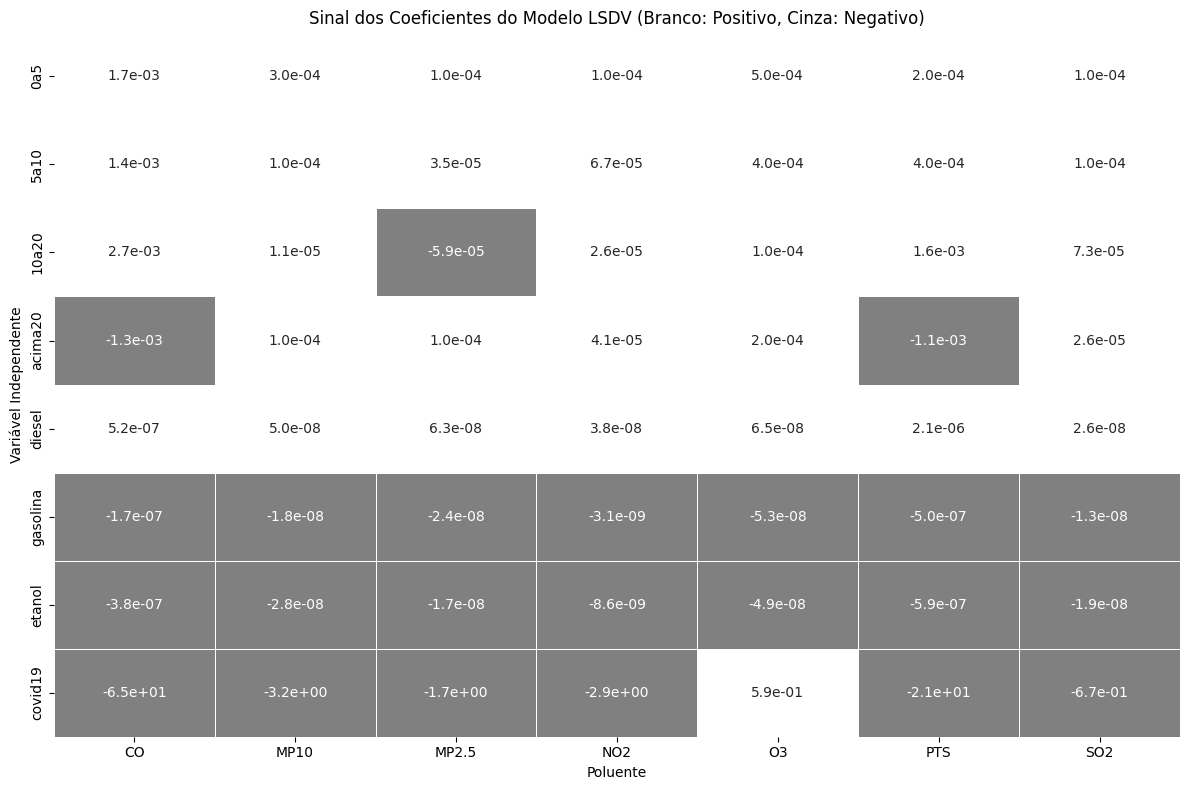

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt

# Definir a ordem desejada das variáveis
variable_order = ['0a5', '5a10', '10a20', 'acima20', 'diesel', 'gasolina', 'etanol', 'covid19']

# Plotar para o Modelo LSDV
lsdv_results_df = filtered_results_df[filtered_results_df['model'] == 'LSDV'].copy()

# Criar tabela dinâmica e reindexar para aplicar a ordem desejada
lsdv_pivot_coef = lsdv_results_df.pivot_table(index='variable', columns='pollutant', values='coef')
lsdv_pivot_coef = lsdv_pivot_coef.reindex(variable_order)

# Usar um mapa de cores personalizado: branco para positivo (1), cinza para negativo (0)
cmap = sns.color_palette(['grey', 'white'])

plt.figure(figsize=(12, 8))
# Usar lsdv_pivot_coef para anotações e manter a máscara para colorir
sns.heatmap(lsdv_pivot_coef > 0, annot=lsdv_pivot_coef, cmap=cmap, fmt='.1e', linewidths=.5, cbar=False)
plt.title('Sinal dos Coeficientes do Modelo LSDV (Branco: Positivo, Cinza: Negativo)')
plt.xlabel('Poluente')
plt.ylabel('Variável Independente')
plt.tight_layout()
plt.show()

## Significância

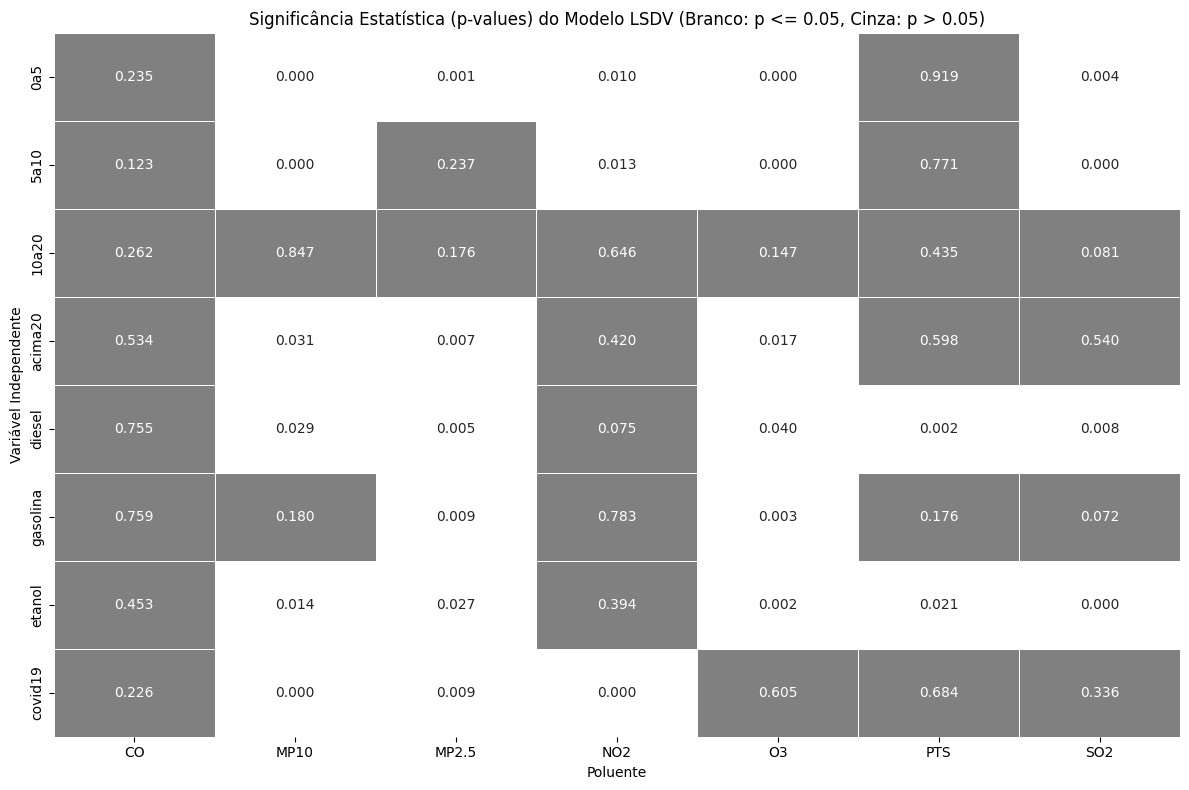

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir a ordem desejada das variáveis
variable_order = ['0a5', '5a10', '10a20', 'acima20', 'diesel', 'gasolina', 'etanol', 'covid19']

#Heatmap para os p-valores do Modelo LSDV
lsdv_pivot = lsdv_results_df.pivot_table(index='variable', columns='pollutant', values='P>|t|')
lsdv_pivot = lsdv_pivot.reindex(variable_order)

# Usar um mapa de cores personalizado: branco para p<=0.05 (0), cinza para p>0.05 (1)
cmap = sns.color_palette(['white', 'grey'])

plt.figure(figsize=(12, 8))
# Usar lsdv_pivot para anotações e a máscara para colorir
sns.heatmap(lsdv_pivot > 0.05, annot=lsdv_pivot, cmap=cmap, fmt=".3f", linewidths=.5, cbar=False)
plt.title('Significância Estatística (p-values) do Modelo LSDV (Branco: p <= 0.05, Cinza: p > 0.05)')
plt.xlabel('Poluente')
plt.ylabel('Variável Independente')
plt.tight_layout()
plt.show()